In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from geomloss import SamplesLoss
from torch.autograd import Function
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.functional import normalize
#from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryF1Score
torch.manual_seed(0)

In [105]:
class TarNet(nn.Module):
    def __init__(self,
                 input_dim,
                 regularization=.01):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(input_dim, 200)
        self.encoder2 = nn.Linear(200, 200)
        self.encoder3 = nn.Linear(200, 200)

        self.regressor1_y0 = nn.Sequential(
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressorO_y0 = nn.Linear(100, 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressorO_y1 = nn.Linear(100, 1)


    def forward(self, inputs):
        x = nn.functional.elu(self.encoder1(inputs))
        x = nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(x))

        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)

        concat = torch.cat((y0, y1,phi), 1)
        return concat

In [106]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [107]:
def get_data(data_type,file_num):

    if(data_type=='train'):
        data=pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_train_{file_num}.csv")
    else:
        data = pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_test_{file_num}.csv")

    x_data=pd.concat([data.iloc[:,0], data.iloc[:, 1:30]], axis = 1)
    #x_data=data.iloc[:, 5:30]
    y_data=data.iloc[:, 1]
    return x_data,y_data

In [108]:
def get_dataloader(x_data,y_data,batch_size):

    x_train_sr=x_data[x_data['treatment']==0]
    y_train_sr=y_data[x_data['treatment']==0]
    x_train_tr=x_data[x_data['treatment']==1]
    y_train_tr=y_data[x_data['treatment']==1]


    train_data_sr = Data(np.array(x_train_sr), np.array(y_train_sr))
    train_dataloader_sr = DataLoader(dataset=train_data_sr, batch_size=batch_size)

    train_data_tr = Data(np.array(x_train_tr), np.array(y_train_tr))
    train_dataloader_tr = DataLoader(dataset=train_data_tr, batch_size=batch_size)


    return train_dataloader_sr, train_dataloader_tr

In [109]:
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = torch.sum((1. - t_true) * torch.square(y_true - y0_pred))
    loss1 = torch.sum(t_true * torch.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

In [110]:
def calc_mmdsq(Phi, t):
    Phic, Phit = torch.split(Phi, [torch.sum(t == 0), torch.sum(t == 1)], dim=0)
    sig=0.1
    #p=1e-4
    p=0.5
    sig = torch.tensor(sig)
    Kcc = torch.exp(-torch.cdist(Phic, Phic, 2.0001) / torch.sqrt(sig))
    Kct = torch.exp(-torch.cdist(Phic, Phit, 2.0001) / torch.sqrt(sig))
    Ktt = torch.exp(-torch.cdist(Phit, Phit, 2.0001) / torch.sqrt(sig))

    m = Phic.shape[0]
    n = Phit.shape[0]

    mmd = (1 - p) ** 2 / (m * m) * (Kcc.sum() - m)
    mmd += p ** 2 / (n * n) * (Ktt.sum() - n)
    mmd -= - 2 * p * (1 - p) / (m * n) * Kct.sum()
    mmd *= 4
    '''
    mmd = (1 - p) ** 2 / (m * (m - 1)) * (Kcc.sum() - m)
    mmd += p ** 2 / (n * (n - 1)) * (Ktt.sum() - n)
    mmd -= - 2 * p * (1 - p) / (m * n) * Kct.sum()
    mmd *= 4
    '''
    return mmd

def mmdsq_loss(concat_true,concat_pred):
    t_true = concat_true[:, 1]
    p=split_pred(concat_pred)
    mmdsq_loss = torch.mean(calc_mmdsq(p['phi'],t_true))
    return mmdsq_loss

def split_pred(concat_pred):
      #generic helper to make sure we dont make mistakes
    preds={}
    preds['y0_pred'] = concat_pred[:, 0]
    preds['y1_pred'] = concat_pred[:, 1]
    preds['phi'] = concat_pred[:, 2:]
    return preds

def calc_wasse(Phi):
    
    loss1 = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
    num_zero=torch.zeros((Phi.shape[0]),1)
    num_ones=torch.ones((Phi.shape[0]),1)
    phi_zero=torch.cat((Phi,num_zero),1)
    phi_ones=torch.cat((Phi,num_ones),1)
    
    wasser = loss1(phi_zero, phi_ones)
 
    return wasser


def cfr_loss(concat_true,concat_pred):
    alpha=1
    lossR = regression_loss(concat_true,concat_pred)
    lossIPM = mmdsq_loss(concat_true,concat_pred)
    wass_loss=calc_wasse(concat_pred[:,2:])
    return lossR +wass_loss+alpha*lossIPM


In [111]:
def cal_pehe(i):
    data,y=get_data('test',i)

    data=data.to_numpy()
    data=torch.from_numpy(data.astype(np.float32))



    concat_pred=net(data[:,5:30])
    #dont forget to rescale the outcome before estimation!
    #y0_pred = data['y_scaler'].inverse_transform(concat_pred[:, 0].reshape(-1, 1))
    #y1_pred = data['y_scaler'].inverse_transform(concat_pred[:, 1].reshape(-1, 1))
    cate_pred=concat_pred[:,1]-concat_pred[:,0]
    cate_true=data[:,4]-data[:,3] #Hill's noiseless true values


    cate_err=torch.mean( torch.square( ( (cate_true) - (cate_pred) ) ) )

    return torch.sqrt(cate_err).item()


In [112]:
def loss_cal(X_data,y_data,net):
    
    x_train_sr=X_data[X_data['treatment']==0]
    y_train_sr=y_data[X_data['treatment']==0]
    x_train_tr=X_data[X_data['treatment']==1]
    y_train_tr=y_data[X_data['treatment']==1]
    xs_t=x_train_sr.iloc[:,0].to_numpy()
    xt_t=x_train_tr.iloc[:,0].to_numpy()
    
    xs=x_train_sr.iloc[:,5:30].to_numpy()
    xt=x_train_tr.iloc[:,5:30].to_numpy()
    xs_t=torch.from_numpy(xs_t.astype(np.float32))
    xt_t=torch.from_numpy(xt_t.astype(np.float32))
    y_train_sr=y_train_sr.to_numpy()
    y_train_tr=y_train_tr.to_numpy()
    xs=torch.from_numpy(xs.astype(np.float32))
    xt=torch.from_numpy(xt.astype(np.float32))
    
    y_train_sr=torch.from_numpy(y_train_sr.astype(np.float32))
    y_train_tr=torch.from_numpy(y_train_tr.astype(np.float32))
    
    
    input_data=torch.cat((xs,xt),0)
    true_y=torch.unsqueeze(torch.cat((y_train_sr,y_train_tr),0), dim=1)
    true_t=torch.unsqueeze(torch.cat((xs_t,xt_t),0), dim=1)
    
    
    concat_true=torch.cat((true_y,true_t),1)
    concat_pred=net(input_data)
    loss=regression_loss(concat_true, concat_pred)
    
    return loss.item()

    
    
    

In [113]:
#criterion_reg=nn.MSELoss()
#criterion_reg=regression_loss(concat_true,concat_pred)
epochs=300
batch_size=32

In [114]:
train_loss=[]
val_loss=[]
pehe_error=[]
num_files=101
for nf in range(1,num_files):
    x_data,y_data=get_data('train',nf)
    X_train, X_val,y_train, y_val = train_test_split(x_data,y_data ,
                                       random_state=42, 
                                       test_size=0.20)
    net=TarNet(25,.01)
    opt_net = torch.optim.Adam(net.parameters(), lr=1e-4)

    for ep in range(1,epochs+1 ):
 
        train_dataloader_sr, train_dataloader_tr=get_dataloader(X_train,y_train,batch_size)
 
        for batch_idx, (train_source_data, train_target_data) in enumerate(zip(train_dataloader_sr, train_dataloader_tr)):
            
            xs,ys=train_source_data
            xt,yt=train_target_data
            
            xs_train=xs[:,5:30]
            xt_train=xt[:,5:30]
            
            train_x=torch.cat((xs_train,xt_train),0)
            train_y=torch.unsqueeze(torch.cat((ys,yt),0), dim=1)
            true_t=torch.unsqueeze(torch.cat((xs[:,0],xt[:,0]),0), dim=1)
            concat_true=torch.cat((train_y,true_t),1)
            concat_pred=net(train_x)
            
            opt_net.zero_grad()
            
            #source_mse=criterion_reg(y0,ys)
            #target_mse=criterion_reg(y1,yt)
            
            #combined loss
            combined_loss=cfr_loss(concat_true,concat_pred)
            #print('Training loss: ',combined_loss.item())
            # backward propagation
            combined_loss.backward()
           
            # optimize
            opt_net.step()
        train_loss.append(loss_cal(X_train,y_train,net))
        val_loss.append(loss_cal(X_val,y_val,net))
    pehe_error.append(cal_pehe(nf))
        

In [115]:
print(pehe_error)

[0.7318174242973328, 0.6824777722358704, 1.0939092636108398, 0.7858610153198242, 1.0539605617523193, 1.4053597450256348, 0.9332302212715149, 0.6342498064041138, 0.672091543674469, 1.0890408754348755, 1.0953013896942139, 0.8094661831855774, 1.1421617269515991, 1.3473392724990845, 0.7694427371025085, 0.7236334681510925, 0.9036110043525696, 1.3081250190734863, 0.947779655456543, 1.1535959243774414, 0.9219589233398438, 0.9500879645347595, 0.9386271238327026, 0.8028010725975037, 0.7035080194473267, 1.0018032789230347, 1.0013563632965088, 0.8061562776565552, 1.4926222562789917, 0.8464391827583313, 0.6493361592292786, 1.2194827795028687, 0.9972955584526062, 0.8409155011177063, 0.780906081199646, 0.7527351379394531, 1.0193794965744019, 0.8916681408882141, 1.0181671380996704, 2.034306287765503, 1.670753002166748, 0.6952239274978638, 0.8863675594329834, 0.6579389572143555, 1.0477006435394287, 1.075119972229004, 0.7937597632408142, 1.3164782524108887, 2.625819206237793, 3.0810775756835938, 0.8890

In [116]:
np.mean(pehe_error)

1.1033434665203095

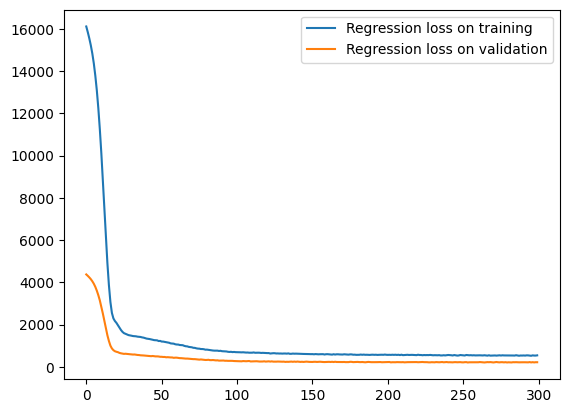

In [261]:
plt.plot(train_loss, label='Regression loss on training')
plt.plot(val_loss, label='Regression loss on validation')
plt.legend()
plt.show()

In [ ]:
#ate_pred=torch.mean(cate_pred)
#print("Estimated ATE (True is 4):", ate_pred.detach().numpy(),'\n\n')

#print("Individualized CATE Estimates: BLUE")
#print(pd.Series(cate_pred.detach().numpy()).plot.kde(color='blue'))
#print("Individualized CATE True: Green")
#print(pd.Series(cate_true.detach().numpy()).plot.kde(color='green'))

#print("\nError CATE Estimates: RED")
#print(pd.Series(cate_pred.detach().numpy()-cate_true.detach().numpy()).plot.kde(color='red'))